In [165]:
import pathlib
train_image = pathlib.Path('/kaggle/input/')
for item in train_image.iterdir():
    print(item)

/kaggle/input/otherimg
/kaggle/input/styletrans


In [166]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/otherimg/other/input (2).jpg
/kaggle/input/otherimg/other/style (2).jpg
/kaggle/input/styletrans/astyle/Art/class3/011.jpg
/kaggle/input/styletrans/astyle/Art/class3/020.jpg
/kaggle/input/styletrans/astyle/Art/class3/019.jpg
/kaggle/input/styletrans/astyle/Art/class3/018.jpg
/kaggle/input/styletrans/astyle/Art/class3/024.jpg
/kaggle/input/styletrans/astyle/Art/class3/016.jpg
/kaggle/input/styletrans/astyle/Art/class3/022.jpg
/kaggle/input/styletrans/astyle/Art/class3/013.jpg
/kaggle/input/styletrans/astyle/Art/class3/012.jpg
/kaggle/input/styletrans/astyle/Art/class3/028.jpg
/kaggle/input/styletrans/astyle/Art/class1/006.jpg
/kaggle/input/styletrans/astyle/Art/class1/002.jpg
/kaggle/input/styletrans/astyle/Art/class1/009.jpg
/kaggle/input/styletrans/astyle/Art/class1/007.jpg
/kaggle/input/styletrans/astyle/Art/class1/001.jpg
/kaggle/input/styletrans/astyle/Art/class1/005.jpg
/kaggle/input/styletrans/astyle/Art/class1/003.jpg
/kaggle/input/styletrans/astyle/Art/class1/008.

In [167]:

import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '4'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import shutil
from glob import glob

from tensorboardX import SummaryWriter

import numpy as np
import multiprocessing

import copy
from tqdm import tqdm
from collections import defaultdict

import horovod.torch as hvd
import torch.utils.data.distributed


import time

from pprint import pprint
display = pprint

hvd.init()


device = torch.device("cuda:%s" %hvd.local_rank() if torch.cuda.is_available() else "cpu")

In [168]:
#设置超参数
is_hvd = False
tag = 'nohvd'
base = 32
style_weight = 50
content_weight = 1
tv_weight = 1e-6
epochs = 22

batch_size = 8
width = 256

verbose_hist_batch = 100
verbose_image_batch = 800

model_name = f'metanet_base{base}_style{style_weight}_tv{tv_weight}_tag{tag}'
print(f'model_name: {model_name}, rank: {hvd.rank()}')

model_name: metanet_base32_style50_tv1e-06_tagnohvd, rank: 0


In [169]:
def rmrf(path):
    try:
        shutil.rmtree(path)
    except:
        pass

for f in glob('runs/*/.AppleDouble'):
    rmrf(f)

rmrf('runs/' + model_name)

In [170]:
vgg16 = models.vgg16(pretrained=True)

In [171]:
#下载vgg19
vgg = models.vgg19(pretrained=True).features


In [172]:
for param in vgg.parameters():
    param.requires_grad_(False)

In [173]:
#层次展示
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [174]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
from collections import defaultdict



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [175]:
#构建VGG类
class VGG(nn.Module):

    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
        for p in self.parameters():
            p.requires_grad = False
    
    def forward(self, x):
        outs = []
        for name, module in self.features._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                outs.append(x)
        return outs

In [176]:
#定义卷积方式
class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(MyConv2D, self).__init__()
        self.weight = torch.zeros((out_channels, in_channels, kernel_size, kernel_size)).to(device)
        self.bias = torch.zeros(out_channels).to(device)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.stride = (stride, stride)
    
    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride)
    
    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        return s.format(**self.__dict__)

In [177]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            *ConvLayer(channels, channels, kernel_size=3, stride=1), 
            *ConvLayer(channels, channels, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.conv(x) + x


In [178]:
def ConvLayer(in_channels, out_channels, kernel_size=3, stride=1, 
    upsample=None, instance_norm=True, relu=True, trainable=False):
    layers = []
    if upsample:
        layers.append(nn.Upsample(mode='nearest', scale_factor=upsample))
    layers.append(nn.ReflectionPad2d(kernel_size // 2))
    if trainable:
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    else:
        layers.append(MyConv2D(in_channels, out_channels, kernel_size, stride))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if relu:
        layers.append(nn.ReLU())
    return layers

In [179]:
class TransformNet(nn.Module):
    def __init__(self, base=8):
        super(TransformNet, self).__init__()
        self.base = base
        self.weights = []
        self.downsampling = nn.Sequential(
            *ConvLayer(3, base, kernel_size=9, trainable=True), 
            *ConvLayer(base, base*2, kernel_size=3, stride=2), 
            *ConvLayer(base*2, base*4, kernel_size=3, stride=2), 
        )
        self.residuals = nn.Sequential(*[ResidualBlock(base*4) for i in range(5)])
        self.upsampling = nn.Sequential(
            *ConvLayer(base*4, base*2, kernel_size=3, upsample=2),
            *ConvLayer(base*2, base, kernel_size=3, upsample=2),
            *ConvLayer(base, 3, kernel_size=9, instance_norm=False, relu=False, trainable=True),
        )
        self.get_param_dict()
    
    def forward(self, X):
        y = self.downsampling(X)
        y = self.residuals(y)
        y = self.upsampling(y)
        return y
    
    def get_param_dict(self):
        """找出该网络所有 MyConv2D 层，计算它们需要的权值数量"""
        param_dict = defaultdict(int)
        def dfs(module, name):
            for name2, layer in module.named_children():
                dfs(layer, '%s.%s' % (name, name2) if name != '' else name2)
            if module.__class__ == MyConv2D:
                param_dict[name] += int(np.prod(module.weight.shape))
                param_dict[name] += int(np.prod(module.bias.shape))
        dfs(self, '')
        return param_dict
    
    def set_my_attr(self, name, value):
        # 下面这个循环是一步步遍历类似 residuals.0.conv.1 的字符串，找到相应的权值
        target = self
        for x in name.split('.'):
            if x.isnumeric():
                target = target.__getitem__(int(x))
            else:
                target = getattr(target, x)
        
        # 设置对应的权值
        n_weight = np.prod(target.weight.shape)
        target.weight = value[:n_weight].view(target.weight.shape)
        target.bias = value[n_weight:].view(target.bias.shape)
    
    def set_weights(self, weights, i=0):
        """输入权值字典，对该网络所有的 MyConv2D 层设置权值"""
        for name, param in weights.items():
            self.set_my_attr(name, weights[name][i])



In [180]:
#建立metanet类
class MetaNet(nn.Module):
    def __init__(self, param_dict):
        super(MetaNet, self).__init__()
        self.param_num = len(param_dict)
        self.hidden = nn.Linear(1920, 128*self.param_num)
        self.fc_dict = {}
        for i, (name, params) in enumerate(param_dict.items()):
            self.fc_dict[name] = i
            setattr(self, 'fc{}'.format(i+1), nn.Linear(128, params))
    
    def forward(self, mean_std_features):
        hidden = F.relu(self.hidden(mean_std_features))
        filters = {}
        for name, i in self.fc_dict.items():
            fc = getattr(self, 'fc{}'.format(i+1))
            filters[name] = fc(hidden[:,i*128:(i+1)*128])
        return filters

In [181]:
vgg16 = VGG(vgg16.features[:23]).to(device).eval()

In [182]:
class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(MyConv2D, self).__init__()
        self.weight = torch.zeros((out_channels, in_channels, kernel_size, kernel_size)).to(device)
        self.bias = torch.zeros(out_channels).to(device)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.stride = (stride, stride)

In [183]:
transform_net = TransformNet(base).to(device)
transform_net.get_param_dict()

defaultdict(int,
            {'downsampling.5': 18496,
             'downsampling.9': 73856,
             'residuals.0.conv.1': 147584,
             'residuals.0.conv.5': 147584,
             'residuals.1.conv.1': 147584,
             'residuals.1.conv.5': 147584,
             'residuals.2.conv.1': 147584,
             'residuals.2.conv.5': 147584,
             'residuals.3.conv.1': 147584,
             'residuals.3.conv.5': 147584,
             'residuals.4.conv.1': 147584,
             'residuals.4.conv.5': 147584,
             'upsampling.2': 73792,
             'upsampling.7': 18464})

In [184]:
#定义metanet
metanet = MetaNet(transform_net.get_param_dict()).to(device)

In [185]:
#工具代码
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]
tensor_normalizer = transforms.Normalize(mean=cnn_normalization_mean, std=cnn_normalization_std)
epsilon = 1e-5


def preprocess_image(image, target_width=None):
    """输入 PIL.Image 对象，输出标准化后的四维 tensor"""
    if target_width:
        t = transforms.Compose([
            transforms.Resize(target_width), 
            transforms.CenterCrop(target_width), 
            transforms.ToTensor(), 
            tensor_normalizer, 
        ])
    else:
        t = transforms.Compose([
            transforms.ToTensor(), 
            tensor_normalizer, 
        ])
    return t(image).unsqueeze(0)


def image_to_tensor(image, target_width=None):
    """输入 OpenCV 图像，范围 0~255，BGR 顺序，输出标准化后的四维 tensor"""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    return preprocess_image(image, target_width)


def read_image(path, target_width=None):
    """输入图像路径，输出标准化后的四维 tensor"""
    image = Image.open(path)
    return preprocess_image(image, target_width)


def recover_image(tensor):
    """输入 GPU 上的四维 tensor，输出 0~255 范围的三维 numpy 矩阵，RGB 顺序"""
    image = tensor.detach().cpu().numpy()
    image = image * np.array(cnn_normalization_std).reshape((1, 3, 1, 1)) + \
    np.array(cnn_normalization_mean).reshape((1, 3, 1, 1))
    return (image.transpose(0, 2, 3, 1) * 255.).clip(0, 255).astype(np.uint8)[0]


def recover_tensor(tensor):
    m = torch.tensor(cnn_normalization_mean).view(1, 3, 1, 1).to(tensor.device)
    s = torch.tensor(cnn_normalization_std).view(1, 3, 1, 1).to(tensor.device)
    tensor = tensor * s + m
    return tensor.clamp(0, 1)


def imshow(tensor, title=None):
    """输入 GPU 上的四维 tensor，然后绘制该图像"""
    image = recover_image(tensor)
    print(image.shape)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


def mean_std(features):
    """输入 VGG16 计算的四个特征，输出每张特征图的均值和标准差，长度为1920"""
    mean_std_features = []
    for x in features:
        x = x.view(*x.shape[:2], -1)
        x = torch.cat([x.mean(-1), torch.sqrt(x.var(-1) + epsilon)], dim=-1)
        n = x.shape[0]
        x2 = x.view(n, 2, -1).transpose(2, 1).contiguous().view(n, -1) # 【mean, ..., std, ...] to [mean, std, ...]
        mean_std_features.append(x2)
    mean_std_features = torch.cat(mean_std_features, dim=-1)
    return mean_std_features


class Smooth:
    # 对输入的数据进行滑动平均
    def __init__(self, windowsize=100):
        self.window_size = windowsize
        self.data = np.zeros((self.window_size, 1), dtype=np.float32)
        self.index = 0
    
    def __iadd__(self, x):
        if self.index == 0:
            self.data[:] = x
        self.data[self.index % self.window_size] = x
        self.index += 1
        return self
    
    def __float__(self):
        return float(self.data.mean())
    
    def __format__(self, f):
        return self.__float__().__format__(f)

    
def im_convert(tensor):
    """ 展示图片. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

def get_features(image, model, layers=None):
    """ 通过模型向前运行图像，获得一组层的特性。默认层用于VGGNet匹配
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

def gram_matrix(tensor):
    """ 计算给定张量的gram矩阵
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [186]:
for dirname, _, filenames in os.walk('/kaggle/input/styletrans/astyle/Art'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/styletrans/astyle/Art/class3/011.jpg
/kaggle/input/styletrans/astyle/Art/class3/020.jpg
/kaggle/input/styletrans/astyle/Art/class3/019.jpg
/kaggle/input/styletrans/astyle/Art/class3/018.jpg
/kaggle/input/styletrans/astyle/Art/class3/024.jpg
/kaggle/input/styletrans/astyle/Art/class3/016.jpg
/kaggle/input/styletrans/astyle/Art/class3/022.jpg
/kaggle/input/styletrans/astyle/Art/class3/013.jpg
/kaggle/input/styletrans/astyle/Art/class3/012.jpg
/kaggle/input/styletrans/astyle/Art/class3/028.jpg
/kaggle/input/styletrans/astyle/Art/class1/006.jpg
/kaggle/input/styletrans/astyle/Art/class1/002.jpg
/kaggle/input/styletrans/astyle/Art/class1/009.jpg
/kaggle/input/styletrans/astyle/Art/class1/007.jpg
/kaggle/input/styletrans/astyle/Art/class1/001.jpg
/kaggle/input/styletrans/astyle/Art/class1/005.jpg
/kaggle/input/styletrans/astyle/Art/class1/003.jpg
/kaggle/input/styletrans/astyle/Art/class1/008.jpg
/kaggle/input/styletrans/astyle/Art/class1/004.jpg
/kaggle/input/styletrans/astyle

In [187]:

import pathlib
train_image = pathlib.Path('/kaggle/input/styletrans/astyle')
for item in train_image.iterdir():
    print(item)


/kaggle/input/styletrans/astyle/Art
/kaggle/input/styletrans/astyle/coco


载入数据集
During training, each content image or style image is resized to keep the smallest dimension in the range [256, 480], and randomly cropped regions of size 256 × 256.

载入 COCO 数据集和 WikiArt 数据集
The batch size of content images is 8 and the meta network is trained for 20 iterations before changing the style image.

In [188]:
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(width, scale=(256/480, 1), ratio=(1, 1)), 
    transforms.ToTensor(), 
    tensor_normalizer
])

style_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/styletrans/astyle/Art', transform=data_transform)
content_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/styletrans/astyle/coco/', transform=data_transform)

if is_hvd:
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        content_dataset, num_replicas=hvd.size(), rank=hvd.rank())
    content_data_loader = torch.utils.data.DataLoader(content_dataset, batch_size=batch_size, 
        num_workers=multiprocessing.cpu_count(),sampler=train_sampler)
else:
    content_data_loader = torch.utils.data.DataLoader(content_dataset, batch_size=batch_size, 
        shuffle=True, num_workers=multiprocessing.cpu_count())

if not is_hvd or hvd.rank() == 0:
    print(style_dataset)
    print('-'*20)
    print(content_dataset)

Dataset ImageFolder
    Number of datapoints: 30
    Root location: /kaggle/input/styletrans/astyle/Art
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.5333, 1), ratio=(1, 1), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
--------------------
Dataset ImageFolder
    Number of datapoints: 30
    Root location: /kaggle/input/styletrans/astyle/coco/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.5333, 1), ratio=(1, 1), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [189]:
'''
metanet.eval()
transform_net.eval()

rands = torch.rand(4, 3, 256, 256).to(device)
features = vgg16(rands)
weights = metanet(mean_std(features))
transform_net.set_weights(weights)
transformed_images = transform_net(torch.rand(4, 3, 256, 256).to(device))

if not is_hvd or hvd.rank() == 0:
    print('features:')
    display([x.shape for x in features])
    
    print('weights:')
    display([x.shape for x in weights.values()])

    print('transformed_images:')
    display(transformed_images.shape)
'''

"\nmetanet.eval()\ntransform_net.eval()\n\nrands = torch.rand(4, 3, 256, 256).to(device)\nfeatures = vgg16(rands)\nweights = metanet(mean_std(features))\ntransform_net.set_weights(weights)\ntransformed_images = transform_net(torch.rand(4, 3, 256, 256).to(device))\n\nif not is_hvd or hvd.rank() == 0:\n    print('features:')\n    display([x.shape for x in features])\n    \n    print('weights:')\n    display([x.shape for x in weights.values()])\n\n    print('transformed_images:')\n    display(transformed_images.shape)\n"

In [190]:
visualization_style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
visualization_content_images = torch.stack([random.choice(content_dataset)[0] for i in range(3)]).to(device)

In [191]:
import pathlib
train_image = pathlib.Path('/kaggle/input/otherimg/other')
for item in train_image.iterdir():
    print(item)


/kaggle/input/otherimg/other/input (2).jpg
/kaggle/input/otherimg/other/style (2).jpg


In [192]:
#选取测试图片
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

content = load_image('/kaggle/input/otherimg/other/input (2).jpg').to(device)
style = load_image('/kaggle/input/otherimg/other/style (2).jpg', shape=content.shape[-2:]).to(device)

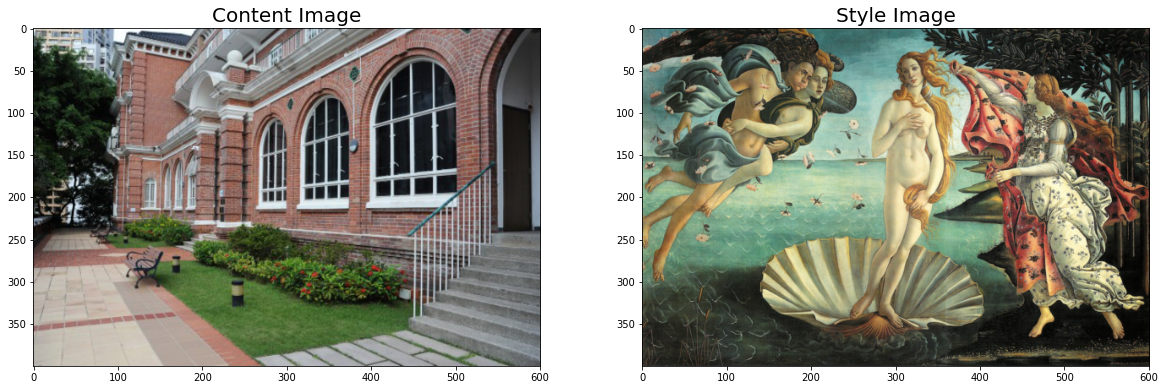

In [193]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax1.set_title("Content Image",fontsize = 20)
ax2.imshow(im_convert(style))
ax2.set_title("Style Image", fontsize = 20)
plt.show()

In [194]:
'''
if not is_hvd or hvd.rank() == 0:
    for f in glob('runs/*/.AppleDouble'):
        rmrf(f)

    rmrf('runs/' + model_name)
    writer = SummaryWriter('runs/'+model_name)
else:
    writer = SummaryWriter('/tmp/'+model_name)

visualization_style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
visualization_content_images = torch.stack([random.choice(content_dataset)[0] for i in range(3)]).to(device)

writer.add_image('content_image', recover_tensor(visualization_content_images), 0)
writer.add_graph(transform_net, (rands, ))

del rands, features, weights, transformed_images

'''

"\nif not is_hvd or hvd.rank() == 0:\n    for f in glob('runs/*/.AppleDouble'):\n        rmrf(f)\n\n    rmrf('runs/' + model_name)\n    writer = SummaryWriter('runs/'+model_name)\nelse:\n    writer = SummaryWriter('/tmp/'+model_name)\n\nvisualization_style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)\nvisualization_content_images = torch.stack([random.choice(content_dataset)[0] for i in range(3)]).to(device)\n\nwriter.add_image('content_image', recover_tensor(visualization_content_images), 0)\nwriter.add_graph(transform_net, (rands, ))\n\ndel rands, features, weights, transformed_images\n\n"

In [195]:
trainable_params = {}
trainable_param_shapes = {}
for model in [vgg16, transform_net, metanet]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params[name] = param
            trainable_param_shapes[name] = param.shape

In [196]:
optimizer = optim.Adam(trainable_params.values(), 1e-3)

if is_hvd:
    optimizer = hvd.DistributedOptimizer(optimizer, 
                                         named_parameters=trainable_params.items())
    params = transform_net.state_dict()
    params.update(metanet.state_dict())
    hvd.broadcast_parameters(params, root_rank=0)

100%|██████████| 4/4 [00:00<00:00, 21.78it/s]


Total loss:  3017557760.0


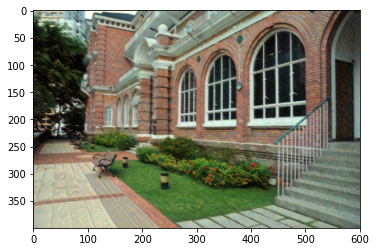

Total loss:  1427722752.0


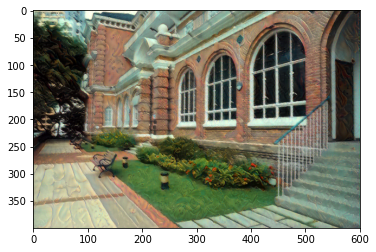

Total loss:  877981760.0


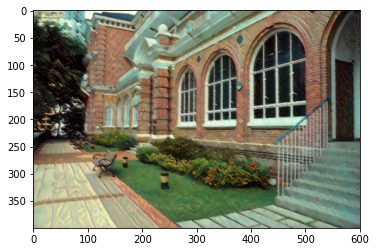

Total loss:  612414272.0


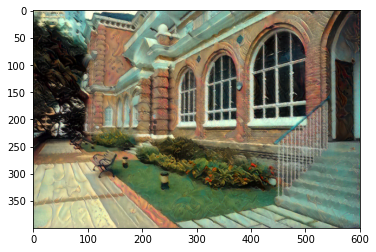

Total loss:  465768512.0


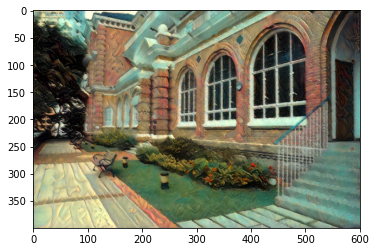

In [197]:
n_batch = len(content_data_loader)
metanet.train()
transform_net.train()

try:
    for epoch in range(epochs):
        smoother = defaultdict(Smooth)
        with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
            for batch, (content_images, _) in pbar:
                n_iter = epoch*n_batch + batch
            
            # 每 20 个 batch 随机挑选一张新的风格图像，计算其特征
            if batch % 20 == 0:
                style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
                style_features = vgg16(style_image)
                style_mean_std = mean_std(style_features)
            
            # 检查纯色
            x = content_images.cpu().numpy()
            if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
                continue
            
            optimizer.zero_grad()
            
            weights = metanet(mean_std(style_features))
            transform_net.set_weights(weights, 0)
            
            content_images = content_images.to(device)
            transformed_images = transform_net(content_images)

            content_features = vgg16(content_images)
            transformed_features = vgg16(transformed_images)
            transformed_mean_std = mean_std(transformed_features)
            
            # content loss
            content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])
            
            # style loss
            style_loss = style_weight * F.mse_loss(transformed_mean_std, 
                                                   style_mean_std.expand_as(transformed_mean_std))
            
            # total variation loss
            y = transformed_images
            tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                                    torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))
            
            # 求和
            loss = content_loss + style_loss + tv_loss 
            
            loss.backward()
            optimizer.step()
            
            smoother['content_loss'] += content_loss.item()
            smoother['style_loss'] += style_loss.item()
            smoother['tv_loss'] += tv_loss.item()
            smoother['loss'] += loss.item()
            
            max_value = max([x.max().item() for x in weights.values()])
        
            writer.add_scalar('loss/loss', loss, n_iter)
            writer.add_scalar('loss/content_loss', content_loss, n_iter)
            writer.add_scalar('loss/style_loss', style_loss, n_iter)
            writer.add_scalar('loss/total_variation', tv_loss, n_iter)
            writer.add_scalar('loss/max', max_value, n_iter)
            
            s = 'Epoch: {} '.format(epoch+1)
            s += 'Content: {:.2f} '.format(smoother['content_loss'])
            s += 'Style: {:.1f} '.format(smoother['style_loss'])
            s += 'Loss: {:.2f} '.format(smoother['loss'])
            s += 'Max: {:.2f}'.format(max_value)
            
            if (batch + 1) % verbose_image_batch == 0:
                transform_net.eval()
                visualization_transformed_images = transform_net(visualization_content_images)
                transform_net.train()
                visualization_transformed_images = torch.cat([style_image, visualization_transformed_images])
                writer.add_image('debug', recover_tensor(visualization_transformed_images), n_iter)
                del visualization_transformed_images
            
            if (batch + 1) % verbose_hist_batch == 0:
                for name, param in weights.items():
                    writer.add_histogram('transform_net.'+name, param.clone().cpu().data.numpy(), 
                                         n_iter, bins='auto')
                
                for name, param in transform_net.named_parameters():
                    writer.add_histogram('transform_net.'+name, param.clone().cpu().data.numpy(), 
                                         n_iter, bins='auto')
                
                for name, param in metanet.named_parameters():
                    l = name.split('.')
                    l.remove(l[-1])
                    writer.add_histogram('metanet.'+'.'.join(l), param.clone().cpu().data.numpy(), 
                                         n_iter, bins='auto')

            pbar.set_description(s)
            
            del transformed_images, weights
    
except:
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    target = content.clone().requires_grad_(True).to(device)
    style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

    content_weight = 1  # alpha
    style_weight = 1e9  # beta
    show_every = 400

# 迭代超参数
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()
    

        


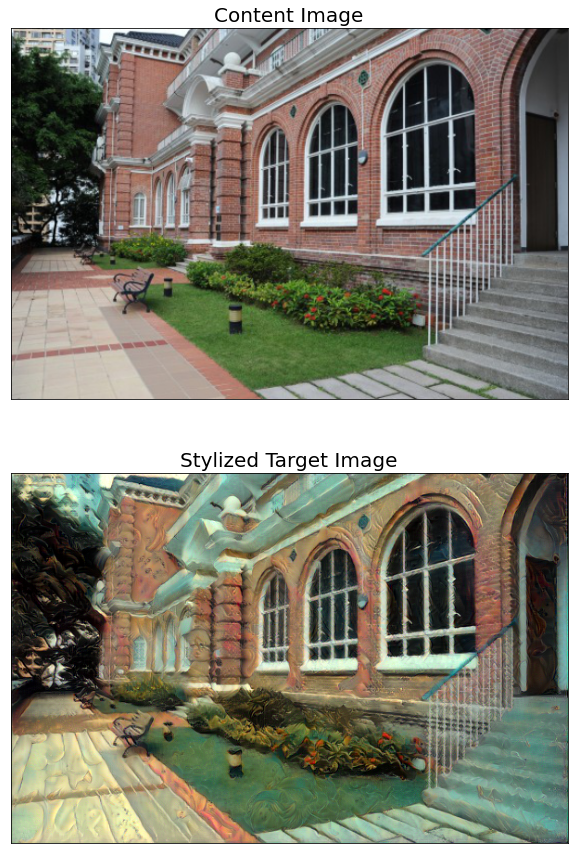

In [198]:
# 展示结果
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize = 20)
ax2.imshow(im_convert(target))
ax2.set_title("Stylized Target Image", fontsize = 20)
ax1.grid(False)
ax2.grid(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()